In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define the data directory
data_dir = "/content/drive/MyDrive/Dataset/train"

# Set the image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 128

# Create an ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Augment data with random rotations
    width_shift_range=0.2,     # Augment data with random horizontal shifts
    height_shift_range=0.2,    # Augment data with random vertical shifts
    horizontal_flip=True,      # Augment data with random horizontal flips
    shear_range=0.2,           # Augment data with random shearing
    zoom_range=0.2             # Augment data with random zooming
)

# Load and preprocess the training dataset
data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True            # Shuffle the data for better training
)

Found 14205 images belonging to 8 classes.


In [ ]:
X, y = data_generator.next()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model building

In [ ]:
# Creating a Sequential model for the first architecture
model = models.Sequential()

# Adding the first convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and input shape of (224, 224, 3)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2))) # Adding max pooling layer

# Adding the second convolutional layer with 64 filters and max pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Adding the third convolutional layer with 128 filters and max pooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add more convolutional and pooling layers as needed

# Flattening the output and adding dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1)) # Adding dropout for regularization
model.add(layers.Dense(8, activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Creating an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    # Add more augmentation options or adjust parameters for under-represented classes
)

# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Creating a base model using MobileNetV2 for transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # Freezing the weights of the pre-trained base model

# Creating a Sequential model for transfer learning
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(8, activation='softmax')
])

# Compiling the transfer learning model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 150  # Adjust the number of epochs based on training progress

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/150
4/4 [==============================] - 9s 1s/step - loss: 1.4307 - accuracy: 0.5098 - val_loss: 0.5501 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/150
4/4 [==============================] - 6s 2s/step - loss: 0.5202 - accuracy: 0.8725 - val_loss: 0.3434 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 3/150
4/4 [==============================] - 5s 1s/step - loss: 0.2503 - accuracy: 0.9412 - val_loss: 0.3096 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 4/150
4/4 [==============================] - 4s 998ms/step - loss: 0.1234 - accuracy: 0.9804 - val_loss: 0.3706 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 5/150
4/4 [==============================] - 5s 1s/step - loss: 0.0559 - accuracy: 1.0000 - val_loss: 0.4063 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 6/150
4/4 [==============================] - 8s 2s/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.3954 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 7/150
4/4 [==============================] - 4s 1s/step - loss: 0.0157 - accuracy: 1.

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
train_loss, train_accuracy = model.evaluate(X_train, y_train)

print("Train accuracy:", train_accuracy * 100)
print("Test accuracy:", test_accuracy * 100)
print("Train loss:", train_loss)
print("Test loss:", test_loss)

4/4 [==============================] - 4s 752ms/step - loss: 0.1270 - accuracy: 0.9902
Train accuracy: 99.01960492134094
Test accuracy: 92.30769276618958
Train loss: 0.12703882157802582
Test loss: 0.30958735942840576


Image as input and processesing it and predicting the waste material category

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess an individual image
image_path = "/content/drive/MyDrive/Dataset/train/leaf_waste/BSpot.jpg"  # Replace with the actual path to your image
img = image.load_img(image_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the pixel values

# Make predictions
predictions = model.predict(img)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Map the class index to class name (if you have a class mapping)
class_names = data_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())
predicted_class_name = class_names[predicted_class]

# Print the predicted class and its probability
print("Predicted Class:", predicted_class_name)
print("Class Probabilities:", predictions)

1/1 [==============================] - 1s 860ms/step
Predicted Class: leaf_waste
Class Probabilities: [[2.2151503e-03 1.7042691e-02 8.8420308e-01 2.9475121e-02 5.7704233e-02
  8.6149274e-05 5.8924244e-03 3.3810686e-03]]


confusion matrix

1/1 [==============================] - 1s 887ms/step


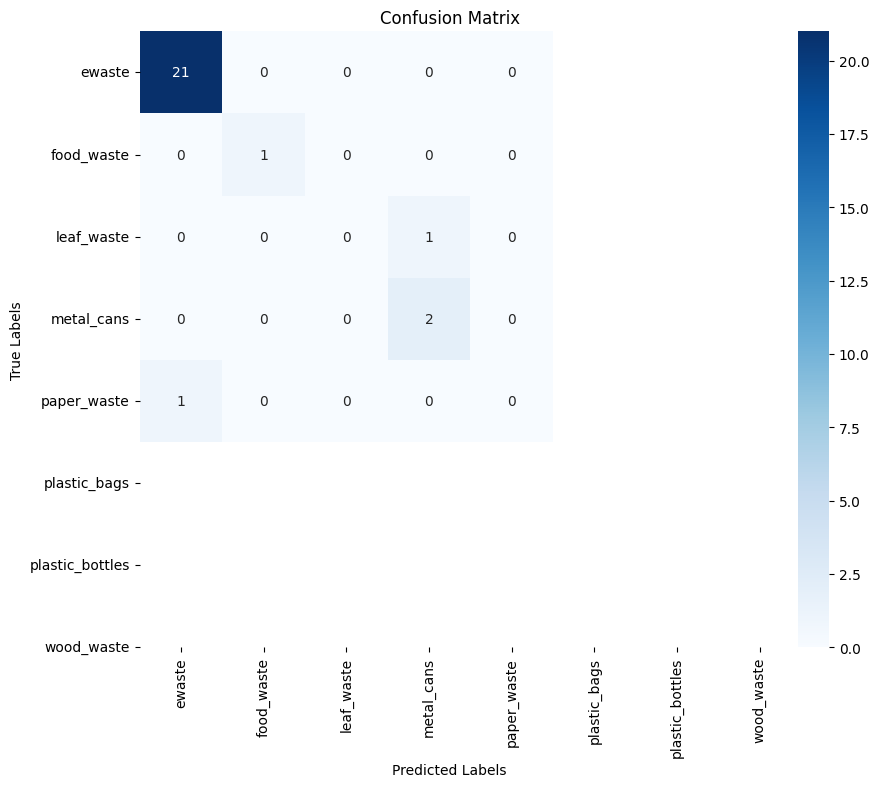

Classification Report:
                  precision    recall  f1-score   support

         ewaste       1.00      1.00      1.00         0
     food_waste       0.95      1.00      0.98        21
     leaf_waste       1.00      1.00      1.00         1
     metal_cans       1.00      0.00      0.00         1
    paper_waste       0.67      1.00      0.80         2
   plastic_bags       1.00      1.00      1.00         0
plastic_bottles       1.00      1.00      1.00         0
     wood_waste       1.00      0.00      0.00         1

      micro avg       0.92      0.92      0.92        26
      macro avg       0.95      0.75      0.72        26
   weighted avg       0.94      0.92      0.89        26



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels for your test set (y_true) and the predicted labels (y_pred)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Specify the correct number of classes for the classification report
class_names_list = list(class_names.values())
print("Classification Report:\n", classification_report(y_true, y_pred_classes, labels=range(len(class_names)), target_names=class_names_list, zero_division=1))


Heat maps

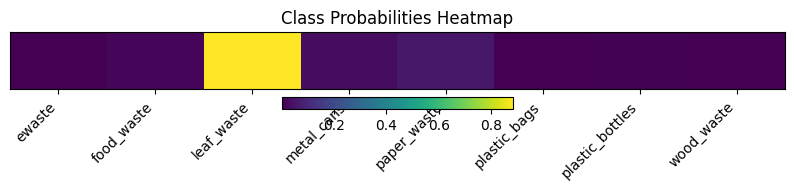

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have class names, replace these with your actual class names
class_names = ['ewaste', 'food_waste', 'leaf_waste', 'metal_cans', 'paper_waste', 'plastic_bags', 'plastic_bottles', 'wood_waste']

# Reshape the probabilities to a 2D array for the heatmap
heatmap_data = predictions.reshape(1, -1)

# Plot the heatmap
plt.figure(figsize=(10, 1))
heatmap = plt.imshow(heatmap_data, cmap='viridis', aspect='auto')

# Show class names on the x-axis
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')

# Hide y-axis ticks and labels
plt.yticks([])

# Display the colorbar
plt.colorbar(heatmap, orientation='horizontal', pad=0.1)

# Set plot title
plt.title('Class Probabilities Heatmap')

# Show the plot
plt.show()
